In [1]:
#!/usr/bin/env python

"""
Code to load an expert policy and generate roll-out data for behavioral cloning.
Example usage:
    python run_expert.py experts/Humanoid-v1.pkl Humanoid-v1 --render \
            --num_rollouts 20

Author of this script and included expert policies: Jonathan Ho (hoj@openai.com)
"""

import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy

In [ ]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('expert_policy_file', type=str)
parser.add_argument('envname', type=str)
parser.add_argument('--render', action='store_true')
parser.add_argument("--max_timesteps", type=int)
parser.add_argument('--num_rollouts', type=int, default=20,
                    help='Number of expert roll outs')
args = parser.parse_args()

## Set the hyperparameters

In [2]:
expert_policy_file = 'experts/Humanoid-v1.pkl'
envname = 'Humanoid-v1'
render = False
num_rollouts = 100
max_timesteps = 500 # (default=1000)

In [139]:
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built


In [26]:
with tf.Session():
    tf_util.initialize()

    import gym
    env = gym.make(envname)
    max_steps = max_timesteps # default is: env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(num_rollouts):
        print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = policy_fn(obs[None,:])
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if render:
                env.render()
            if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
            if steps >= max_steps:
                break
        returns.append(totalr)

    print('returns', returns)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))

    expert_data = {'observations': np.array(observations),
                   'actions': np.array(actions)}
    output_file_name = 'data/' + envname + '_' + str(num_rollouts) + '_data.pkl'
    with open(output_file_name, 'wb') as f:
        pickle.dump(expert_data, f)

Instructions for updating:
Please use tf.global_variables instead.


[2018-01-13 19:01:33,860] From /Volumes/JetDrive/MOOC/UCBerkeley/Reinforcement Learning 2017 Fall/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2018-01-13 19:01:33,861] From /Volumes/JetDrive/MOOC/UCBerkeley/Reinforcement Learning 2017 Fall/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2018-01-13 19:01:33,876] Making new env: Humanoid-v1


iter 0
100/500
200/500
300/500
400/500
500/500
iter 1
100/500
200/500
300/500
400/500
500/500
iter 2
100/500
200/500
300/500
400/500
500/500
iter 3
100/500
200/500
300/500
400/500
500/500
iter 4
100/500
200/500
300/500
400/500
500/500
iter 5
100/500
200/500
300/500
400/500
500/500
iter 6
100/500
200/500
300/500
400/500
500/500
iter 7
100/500
200/500
300/500
400/500
500/500
iter 8
100/500
200/500
300/500
400/500
500/500
iter 9
100/500
200/500
300/500
400/500
500/500
iter 10
100/500
200/500
300/500
400/500
500/500
iter 11
100/500
200/500
300/500
400/500
500/500
iter 12
100/500
200/500
300/500
400/500
500/500
iter 13
100/500
200/500
300/500
400/500
500/500
iter 14
100/500
200/500
300/500
400/500
500/500
iter 15
100/500
200/500
300/500
400/500
500/500
iter 16
100/500
200/500
300/500
400/500
500/500
iter 17
100/500
200/500
300/500
400/500
500/500
iter 18
100/500
200/500
300/500
400/500
500/500
iter 19
100/500
200/500
300/500
400/500
500/500
iter 20
100/500
200/500
300/500
400/500
500/500
it

### result of reward for Expert Policy
- mean return 4915.4291122
- std of return 42.838058301

# Build a NN to learn from the training data

In [124]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [95]:
# Helper function

def load_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.loads(f.read())
    return data

In [96]:
training_data_path = 'data/Humanoid-v1_100_data.pkl'
data = load_data(training_data_path)

In [97]:
# numbers of data points
n_data = len(data['observations'])

In [98]:
# numbers of parameters in one observation
len(data['observations'][0])

376

In [99]:
obs_data = data['observations']
act_data = data['actions']

In [100]:
split_val = int(n_data * .8)

In [110]:
x_train = obs_data[:split_val]
y_train = act_data[:split_val]
x_val = obs_data[split_val:]
y_val = act_data[split_val:]

In [111]:
y_train.shape

(40000, 1, 17)

In [112]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[2])
y_val = y_val.reshape(y_val.shape[0], y_val.shape[2])

In [120]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(40000, 376)
(40000, 17)
(10000, 376)
(10000, 17)


In [121]:
num_epochs = 200
loss_fuc = 'mean_squared_error' # or 'msle'

# construct the callback
filepath="data/best_epoch.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(act_data.shape[2], activation='linear'))
model.compile(loss=loss_fuc, optimizer='adam')


In [122]:
## Start Training
model.summary()
history_w_model = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=num_epochs, batch_size=64, validation_data=(x_val, y_val))

plt.plot(history_w_model.history['loss'], label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history_w_model.history['val_loss'], label='Val_loss')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               96512     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 17)                4369      
Total params: 232,465
Trainable params: 232,465
Non-trainable params: 0
_________________________________________________________________
Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 4s - loss: 2.6289 - val_loss: 0.3635
Epoch 2/200
40000/40000 [==============================] - 3s - loss: 0.3403 - val_loss: 0.2730
Epoch 3/200
40000/40000 [=

40000/40000 [==============================] - 4s - loss: 0.0401 - val_loss: 0.0426
Epoch 31/200
40000/40000 [==============================] - 4s - loss: 0.0398 - val_loss: 0.0452
Epoch 32/200
40000/40000 [==============================] - 4s - loss: 0.0386 - val_loss: 0.0435
Epoch 33/200
40000/40000 [==============================] - 4s - loss: 0.0381 - val_loss: 0.0413
Epoch 34/200
40000/40000 [==============================] - 4s - loss: 0.0373 - val_loss: 0.0409
Epoch 35/200
40000/40000 [==============================] - 4s - loss: 0.0368 - val_loss: 0.0421
Epoch 36/200
40000/40000 [==============================] - 4s - loss: 0.0362 - val_loss: 0.0407
Epoch 37/200
40000/40000 [==============================] - 4s - loss: 0.0354 - val_loss: 0.0385
Epoch 38/200
40000/40000 [==============================] - 4s - loss: 0.0351 - val_loss: 0.0390
Epoch 39/200
40000/40000 [==============================] - 4s - loss: 0.0348 - val_loss: 0.0378
Epoch 40/200
40000/40000 [=================

40000/40000 [==============================] - 4s - loss: 0.0287 - val_loss: 0.0319
Epoch 67/200
40000/40000 [==============================] - 3s - loss: 0.0263 - val_loss: 0.0322
Epoch 68/200
40000/40000 [==============================] - 4s - loss: 0.0266 - val_loss: 0.0328
Epoch 69/200
40000/40000 [==============================] - 4s - loss: 0.0251 - val_loss: 0.0326
Epoch 70/200
40000/40000 [==============================] - 4s - loss: 0.0248 - val_loss: 0.0319
Epoch 71/200
40000/40000 [==============================] - 4s - loss: 0.0248 - val_loss: 0.0317
Epoch 72/200
40000/40000 [==============================] - 4s - loss: 0.0247 - val_loss: 0.0327
Epoch 73/200
40000/40000 [==============================] - 4s - loss: 0.0245 - val_loss: 0.0300
Epoch 74/200
40000/40000 [==============================] - 4s - loss: 0.0245 - val_loss: 0.0316
Epoch 75/200
40000/40000 [==============================] - 4s - loss: 0.0242 - val_loss: 0.0306
Epoch 76/200
40000/40000 [=================

40000/40000 [==============================] - 4s - loss: 0.0213 - val_loss: 0.0281
Epoch 106/200
40000/40000 [==============================] - 4s - loss: 0.0210 - val_loss: 0.0281
Epoch 107/200
40000/40000 [==============================] - 3s - loss: 0.0215 - val_loss: 0.0287
Epoch 108/200
40000/40000 [==============================] - 3s - loss: 0.0214 - val_loss: 0.0267
Epoch 109/200
40000/40000 [==============================] - 4s - loss: 0.0215 - val_loss: 0.0289
Epoch 110/200
40000/40000 [==============================] - 4s - loss: 0.0216 - val_loss: 0.0293
Epoch 111/200
40000/40000 [==============================] - 4s - loss: 0.0212 - val_loss: 0.0269
Epoch 112/200
40000/40000 [==============================] - 4s - loss: 0.0206 - val_loss: 0.0288
Epoch 113/200
40000/40000 [==============================] - 4s - loss: 0.0208 - val_loss: 0.0283
Epoch 114/200
40000/40000 [==============================] - 4s - loss: 0.0209 - val_loss: 0.0270
Epoch 115/200
40000/40000 [=======

40000/40000 [==============================] - 4s - loss: 0.0195 - val_loss: 0.0255
Epoch 144/200
40000/40000 [==============================] - 4s - loss: 0.0193 - val_loss: 0.0258
Epoch 145/200
40000/40000 [==============================] - 4s - loss: 0.0191 - val_loss: 0.0260
Epoch 146/200
40000/40000 [==============================] - 4s - loss: 0.0188 - val_loss: 0.0258
Epoch 147/200
40000/40000 [==============================] - 4s - loss: 0.0198 - val_loss: 0.0251
Epoch 148/200
40000/40000 [==============================] - 4s - loss: 0.0204 - val_loss: 0.0268
Epoch 149/200
40000/40000 [==============================] - 4s - loss: 0.0194 - val_loss: 0.0257
Epoch 150/200
40000/40000 [==============================] - 4s - loss: 0.0187 - val_loss: 0.0257
Epoch 151/200
40000/40000 [==============================] - 4s - loss: 0.0189 - val_loss: 0.0265
Epoch 152/200
40000/40000 [==============================] - 4s - loss: 0.0190 - val_loss: 0.0262
Epoch 153/200
40000/40000 [=======

40000/40000 [==============================] - 4s - loss: 0.0202 - val_loss: 0.0256
Epoch 183/200
40000/40000 [==============================] - 3s - loss: 0.0184 - val_loss: 0.0248
Epoch 184/200
40000/40000 [==============================] - 3s - loss: 0.0187 - val_loss: 0.0271
Epoch 185/200
40000/40000 [==============================] - 4s - loss: 0.0183 - val_loss: 0.0234
Epoch 186/200
40000/40000 [==============================] - 3s - loss: 0.0182 - val_loss: 0.0247
Epoch 187/200
40000/40000 [==============================] - 3s - loss: 0.0179 - val_loss: 0.0239
Epoch 188/200
40000/40000 [==============================] - 3s - loss: 0.0182 - val_loss: 0.0249
Epoch 189/200
40000/40000 [==============================] - 3s - loss: 0.0183 - val_loss: 0.0256
Epoch 190/200
40000/40000 [==============================] - 4s - loss: 0.0186 - val_loss: 0.0256
Epoch 191/200
40000/40000 [==============================] - 4s - loss: 0.0189 - val_loss: 0.0259
Epoch 192/200
40000/40000 [=======

NameError: name 'plt' is not defined

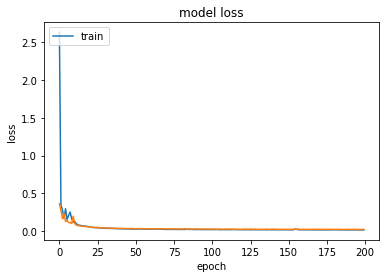

In [125]:
plt.plot(history_w_model.history['loss'], label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history_w_model.history['val_loss'], label='Val_loss')
plt.show()

In [162]:
# load weights into the model
model.load_weights("data/best_epoch.hdf5")
print("Loaded model from disk")

model.compile(loss='mean_squared_error', optimizer='adam')

Loaded model from disk


In [130]:
returns = []  # the returned reward
observations = []
actions = []
for i in range(num_rollouts):
    print('iter', i)
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
        action = model.predict(obs[None,:])  # reshape it as (1, 376)
        observations.append(obs)
        actions.append(action)
        obs, r, done, _ = env.step(action)
        totalr += r
        steps += 1
        if False:  # render it or not
            env.render()
        if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
        if steps >= max_steps:
            break
    returns.append(totalr)

print('returns', returns)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

iter 0
100/500
200/500
300/500
400/500
500/500
iter 1
100/500
iter 2
100/500
200/500
300/500
400/500
500/500
iter 3
100/500
200/500
300/500
iter 4
100/500
200/500
iter 5
100/500
200/500
300/500
400/500
iter 6
100/500
200/500
300/500
400/500
500/500
iter 7
100/500
200/500
300/500
400/500
500/500
iter 8
100/500
200/500
300/500
400/500
500/500
iter 9
100/500
200/500
300/500
400/500
500/500
iter 10
100/500
200/500
300/500
400/500
500/500
iter 11
100/500
200/500
300/500
iter 12
100/500
200/500
300/500
400/500
500/500
iter 13
100/500
200/500
300/500
400/500
iter 14
100/500
200/500
iter 15
iter 16
100/500
200/500
300/500
400/500
500/500
iter 17
100/500
200/500
300/500
400/500
500/500
iter 18
100/500
200/500
iter 19
100/500
200/500
300/500
400/500
500/500
iter 20
100/500
200/500
300/500
400/500
500/500
iter 21
100/500
200/500
300/500
400/500
iter 22
100/500
200/500
300/500
400/500
iter 23
100/500
200/500
300/500
iter 24
100/500
200/500
300/500
400/500
500/500
iter 25
100/500
iter 26
100/500
20

### Result of reward
- mean return 4103.93716085
- std of return 1360.52018715

# DAgger

Get the new data from Expert policy by providing the new observations from our NN policy

In [141]:
with tf.Session():
    tf_util.initialize()
    DAgger_num_rollouts = 100
    DAgger_observations = []
    DAgger_actions = []
    for i in range(DAgger_num_rollouts):
        print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = model.predict(obs[None,:])  # Our policy action
            expert_action = policy_fn(obs[None,:])  # expert policy action
            DAgger_observations.append(obs)
            DAgger_actions.append(expert_action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if False:  # render it or not
                env.render()
            if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
            if steps >= max_steps:
                break
        returns.append(totalr)

Instructions for updating:
Please use tf.global_variables instead.


[2018-01-13 20:28:58,742] From /Volumes/JetDrive/MOOC/UCBerkeley/Reinforcement Learning 2017 Fall/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2018-01-13 20:28:58,744] From /Volumes/JetDrive/MOOC/UCBerkeley/Reinforcement Learning 2017 Fall/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50
iter 51
iter 52
iter 53
iter 54
iter 55
iter 56
iter 57
iter 58
iter 59
iter 60
iter 61
iter 62
iter 63
iter 64
iter 65
iter 66
iter 67
iter 68
iter 69
iter 70
iter 71
iter 72
iter 73
iter 74
iter 75
iter 76
iter 77
iter 78
iter 79
iter 80
iter 81
iter 82
iter 83
iter 84
iter 85
iter 86
iter 87
iter 88
iter 89
iter 90
iter 91
iter 92
iter 93
iter 94
iter 95
iter 96
iter 97
iter 98
iter 99


In [145]:
DAgger_obs = np.array(DAgger_observations)
DAgger_act = np.array(DAgger_actions)

In [146]:
print(DAgger_obs.shape)
print(DAgger_act.shape)

(2910, 376)
(2910, 1, 17)


In [153]:
split_val = int(len(DAgger_obs) * .8)

In [154]:
x_train = DAgger_obs[:split_val]
y_train = DAgger_act[:split_val]
x_val = DAgger_obs[split_val:]
y_val = DAgger_act[split_val:]

In [155]:
y_train.shape

(2328, 1, 17)

In [156]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[2])
y_val = y_val.reshape(y_val.shape[0], y_val.shape[2])

In [157]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(2328, 376)
(2328, 17)
(582, 376)
(582, 17)


In [ ]:
# construct the callback
filepath="data/best_epoch_DAgger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               96512     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 17)                4369      
Total params: 232,465
Trainable params: 232,465
Non-trainable params: 0
_________________________________________________________________
Train on 2328 samples, validate on 582 samples
Epoch 1/200
2328/2328 [==============================] - 0s - loss: 0.3821 - val_loss: 0.1827
Epoch 2/200
2328/2328 [==============================] - 0s - loss: 0.1387 - val_loss: 0.1194
Epoch 3/200
2328/2328 [==========

2328/2328 [==============================] - 0s - loss: 0.0206 - val_loss: 0.0377
Epoch 35/200
2328/2328 [==============================] - 0s - loss: 0.0195 - val_loss: 0.0381
Epoch 36/200
2328/2328 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0379
Epoch 37/200
2328/2328 [==============================] - 0s - loss: 0.0191 - val_loss: 0.0518
Epoch 38/200
2328/2328 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0365
Epoch 39/200
2328/2328 [==============================] - 0s - loss: 0.0147 - val_loss: 0.0341
Epoch 40/200
2328/2328 [==============================] - 0s - loss: 0.0143 - val_loss: 0.0374
Epoch 41/200
2328/2328 [==============================] - 0s - loss: 0.0146 - val_loss: 0.0340
Epoch 42/200
2328/2328 [==============================] - 0s - loss: 0.0138 - val_loss: 0.0366
Epoch 43/200
2328/2328 [==============================] - 0s - loss: 0.0129 - val_loss: 0.0360
Epoch 44/200
2328/2328 [==============================] - 0s - 

2328/2328 [==============================] - 0s - loss: 0.0119 - val_loss: 0.0345
Epoch 74/200
2328/2328 [==============================] - 0s - loss: 0.0120 - val_loss: 0.0336
Epoch 75/200
2328/2328 [==============================] - 0s - loss: 0.0111 - val_loss: 0.0336
Epoch 76/200
2328/2328 [==============================] - 0s - loss: 0.0104 - val_loss: 0.0341
Epoch 77/200
2328/2328 [==============================] - 0s - loss: 0.0101 - val_loss: 0.0331
Epoch 78/200
2328/2328 [==============================] - 0s - loss: 0.0099 - val_loss: 0.0327
Epoch 79/200
2328/2328 [==============================] - 0s - loss: 0.0095 - val_loss: 0.0323
Epoch 80/200
2328/2328 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0313
Epoch 81/200
2328/2328 [==============================] - 0s - loss: 0.0089 - val_loss: 0.0306
Epoch 82/200
2328/2328 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0338
Epoch 83/200
2328/2328 [==============================] - 0s - 

2328/2328 [==============================] - 0s - loss: 0.0095 - val_loss: 0.0304
Epoch 113/200
2328/2328 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0306
Epoch 114/200
2328/2328 [==============================] - 0s - loss: 0.0080 - val_loss: 0.0303
Epoch 115/200
2328/2328 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0300
Epoch 116/200
2328/2328 [==============================] - 0s - loss: 0.0087 - val_loss: 0.0339
Epoch 117/200
2328/2328 [==============================] - 0s - loss: 0.0116 - val_loss: 0.0392
Epoch 118/200
2328/2328 [==============================] - 0s - loss: 0.0215 - val_loss: 0.0383
Epoch 119/200
2328/2328 [==============================] - 0s - loss: 0.0353 - val_loss: 0.0606
Epoch 120/200
2328/2328 [==============================] - 0s - loss: 0.0325 - val_loss: 0.0442
Epoch 121/200
2328/2328 [==============================] - 0s - loss: 0.0244 - val_loss: 0.0384
Epoch 122/200
2328/2328 [=============================

2328/2328 [==============================] - 0s - loss: 0.0076 - val_loss: 0.0277
Epoch 153/200
2328/2328 [==============================] - 0s - loss: 0.0085 - val_loss: 0.0287
Epoch 154/200
2328/2328 [==============================] - 0s - loss: 0.0084 - val_loss: 0.0292
Epoch 155/200
2328/2328 [==============================] - 0s - loss: 0.0080 - val_loss: 0.0297
Epoch 156/200
2328/2328 [==============================] - 0s - loss: 0.0084 - val_loss: 0.0280
Epoch 157/200
2328/2328 [==============================] - 0s - loss: 0.0076 - val_loss: 0.0280
Epoch 158/200
2328/2328 [==============================] - 0s - loss: 0.0079 - val_loss: 0.0287
Epoch 159/200
2328/2328 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0283
Epoch 160/200
2328/2328 [==============================] - 0s - loss: 0.0076 - val_loss: 0.0284
Epoch 161/200
2328/2328 [==============================] - 0s - loss: 0.0075 - val_loss: 0.0288
Epoch 162/200
2328/2328 [=============================

2328/2328 [==============================] - 0s - loss: 0.0067 - val_loss: 0.0274
Epoch 192/200
2328/2328 [==============================] - 0s - loss: 0.0065 - val_loss: 0.0273
Epoch 193/200
2328/2328 [==============================] - 0s - loss: 0.0069 - val_loss: 0.0267
Epoch 194/200
2328/2328 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0341
Epoch 195/200
2328/2328 [==============================] - 0s - loss: 0.0103 - val_loss: 0.0332
Epoch 196/200
2328/2328 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0279
Epoch 197/200
2328/2328 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0280
Epoch 198/200
2328/2328 [==============================] - 0s - loss: 0.0069 - val_loss: 0.0297
Epoch 199/200
2328/2328 [==============================] - 0s - loss: 0.0068 - val_loss: 0.0263
Epoch 200/200
2328/2328 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0292


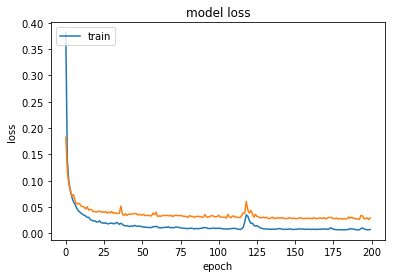

In [163]:
## Start Training with new DAgger Data
model.summary()
history_w_model = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=num_epochs, batch_size=64, validation_data=(x_val, y_val))

plt.plot(history_w_model.history['loss'], label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history_w_model.history['val_loss'], label='Val_loss')
plt.show()

In [164]:
# load weights into the model
model.load_weights("data/best_epoch_DAgger.hdf5")
print("Loaded model from disk")

model.compile(loss='mean_squared_error', optimizer='adam')

Loaded model from disk


In [165]:
returns = []  # the returned reward
observations = []
actions = []
for i in range(num_rollouts):
    print('iter', i)
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
        action = model.predict(obs[None,:])  # reshape it as (1, 376)
        observations.append(obs)
        actions.append(action)
        obs, r, done, _ = env.step(action)
        totalr += r
        steps += 1
        if False:  # render it or not
            env.render()
        if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
        if steps >= max_steps:
            break
    returns.append(totalr)

print('returns', returns)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

iter 0
100/500
200/500
300/500
iter 1
100/500
200/500
300/500
400/500
500/500
iter 2
100/500
200/500
300/500
iter 3
100/500
200/500
300/500
400/500
500/500
iter 4
100/500
200/500
300/500
400/500
500/500
iter 5
100/500
200/500
300/500
400/500
500/500
iter 6
100/500
200/500
300/500
400/500
500/500
iter 7
100/500
iter 8
100/500
200/500
300/500
iter 9
100/500
200/500
300/500
400/500
500/500
iter 10
100/500
200/500
300/500
400/500
500/500
iter 11
100/500
200/500
iter 12
100/500
200/500
300/500
400/500
500/500
iter 13
100/500
200/500
300/500
400/500
500/500
iter 14
100/500
200/500
300/500
400/500
500/500
iter 15
100/500
200/500
300/500
400/500
500/500
iter 16
100/500
200/500
300/500
400/500
500/500
iter 17
100/500
200/500
300/500
400/500
500/500
iter 18
100/500
200/500
300/500
400/500
500/500
iter 19
100/500
200/500
300/500
400/500
500/500
iter 20
100/500
iter 21
100/500
200/500
300/500
400/500
500/500
iter 22
100/500
200/500
300/500
400/500
500/500
iter 23
100/500
iter 24
100/500
200/500
30

# The result of reward
- mean return 4308.36960702
- std of return 1085.95059494